# Using Natural Language Processing and Sentiment Analysis to Analyze Disneyland Reviews

### Objective  

* To create a model that will classify reviews as either positive or negative
* To identify what aspects of a Disneyland visit people are pleased or displeased with


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from string import punctuation
from itertools import chain
import re
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif

from sklearn import svm
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.tokenize import word_tokenize
%matplotlib inline

In [60]:
df= pd.read_csv('DisneylandReviews.csv',index_col=0, encoding='latin1')

In [61]:
df.head(10)

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
Review_ID,,,,,
670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong
670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong
670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong
670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong


In [62]:
df.shape

(42656, 5)

In [63]:
def produce_missing_report(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

In [64]:
produce_missing_report(df)

,column_name,percent_missing
Rating,Rating,0.0
Year_Month,Year_Month,0.0
Reviewer_Location,Reviewer_Location,0.0
Review_Text,Review_Text,0.0
Branch,Branch,0.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42656 entries, 670772142 to 1536786
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rating             42656 non-null  int64 
 1   Year_Month         42656 non-null  object
 2   Reviewer_Location  42656 non-null  object
 3   Review_Text        42656 non-null  object
 4   Branch             42656 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [66]:
df['Branch'].value_counts()

Disneyland_California    19406
Disneyland_Paris         13630
Disneyland_HongKong       9620
Name: Branch, dtype: int64

In [67]:
df['Year_Month'].str.match('[0-9]{4}-[0-9]').all()

False

In [68]:
df['Year_Month'].unique()

array(['2019-4', '2019-5', '2019-3', '2018-9', '2019-1', '2018-11',
       '2018-12', '2018-6', '2019-2', '2018-10', '2018-8', '2018-5',
       '2018-4', '2018-7', '2018-3', '2018-2', 'missing', '2018-1',
       '2017-12', '2017-11', '2017-6', '2017-10', '2017-9', '2017-8',
       '2017-7', '2017-5', '2017-4', '2017-3', '2017-2', '2017-1',
       '2016-12', '2016-11', '2016-10', '2016-9', '2016-8', '2016-7',
       '2016-6', '2016-5', '2016-4', '2016-3', '2016-2', '2016-1',
       '2015-12', '2015-11', '2015-10', '2015-9', '2015-8', '2015-7',
       '2015-6', '2015-5', '2015-4', '2015-3', '2015-2', '2015-1',
       '2014-12', '2014-11', '2014-10', '2014-9', '2014-8', '2014-7',
       '2014-6', '2014-5', '2014-4', '2014-3', '2014-2', '2014-1',
       '2013-12', '2013-11', '2013-10', '2013-9', '2013-8', '2013-7',
       '2013-6', '2013-5', '2013-4', '2013-3', '2013-2', '2013-1',
       '2012-12', '2012-11', '2012-10', '2012-9', '2012-8', '2012-7',
       '2012-6', '2012-5', '2012-4', '20

In [69]:
missing= df[df['Year_Month']=='missing']
missing.shape

(2613, 5)

We see that despite the missing values report showing there are no null values, there are many data points with the value "missing" which require imputation

In [70]:
def clean_Year(x):
    if x=='missing':
        x='0'
    else:
        x=x[slice(0,4)]
    return x

df['Year']=df['Year_Month'].apply(clean_Year)

In [71]:
def clean_Month(x):
    if x=='missing':
        x='0'
    else:
        x=x[slice(5,6)]
    return x

df['Month']=df['Year_Month'].apply(clean_Month)

In [72]:
df=df.drop(['Year_Month'], axis=1)

In [73]:
df.head(5)

,Rating,Reviewer_Location,Review_Text,Branch,Year,Month
Review_ID,,,,,,
670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4
670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5
670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4
670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4
670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4


In [74]:
df['Rating'].value_counts()

5    23146
4    10775
3     5109
2     2127
1     1499
Name: Rating, dtype: int64

In [75]:
df = df[df['Rating'] !=3] #returns a boolean series
y_map = {1:0, 2:0, 4:1, 5:1} #scores 1-5 without 3, replace positive with 1, negative with 0
y = df['Rating'].map(y_map)
df['sentiment']=y

In [76]:
df['sentiment'].value_counts()

1    33921
0     3626
Name: sentiment, dtype: int64

In [77]:
df.head(10)

,Rating,Reviewer_Location,Review_Text,Branch,Year,Month,sentiment
Review_ID,,,,,,,
670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,1
670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,1
670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,1
670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,1
670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,1
670585330,5,India,Great place! Your day will go by and you won't...,Disneyland_HongKong,2019,4,1
670571027,2,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong,2019,4,0
670570869,5,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong,2019,3,1
670443403,5,United States,Disneyland never cease to amaze me! I've been ...,Disneyland_HongKong,2019,4,1


In [78]:
df['Reviewer_Location'].unique()

array(['Australia', 'Philippines', 'United Arab Emirates',
       'United Kingdom', 'India', 'United States', 'Canada',
       'Myanmar (Burma)', 'Hong Kong', 'China', 'Singapore', 'Indonesia',
       'Qatar', 'Sri Lanka', 'New Zealand', 'Uganda', 'Malaysia',
       'Thailand', 'Austria', 'Saudi Arabia', 'Japan', 'South Korea',
       'Turkey', 'Macau', 'South Africa', 'Mauritius', 'Brazil', 'Kenya',
       'Portugal', 'Zambia', 'France', 'Vietnam', 'Taiwan', 'Oman',
       'Israel', 'Sweden', 'Norway', 'Netherlands', 'Barbados', 'Finland',
       'Egypt', 'Bosnia and Herzegovina', 'Bahrain', 'Maldives', 'Russia',
       'Brunei', 'Germany', 'Chile', 'Ireland', 'Isle of Man', 'Pakistan',
       'Romania', 'Ukraine', 'Greece', 'Switzerland', 'Spain', 'Estonia',
       "Côte d'Ivoire", 'Guam', 'Italy', 'Botswana', 'Kuwait', 'Cambodia',
       'Denmark', 'Bangladesh', 'Argentina', 'Peru', 'Lithuania', 'Iran',
       'Mali', 'Mongolia', 'Zimbabwe', 'Seychelles', 'Puerto Rico',
       'Hung

In [79]:
df['Year'].sort_values(ascending=True).unique()

array(['0', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019'], dtype=object)

In [80]:
def clean_text(words):
    tokens=words.split(" ") #split string reviews into words

    tokens = [w.lower() for w in tokens]    #convert to lowercase

    tokens= [w.replace("disneyland", " ") for w in tokens] #remove disney and disneyland beacuse they add no value
    tokens= [w.replace("disney", " ") for w in tokens]

    table = str.maketrans('', '', string.punctuation)   #remove punctuation from each word
    stripped = [w.translate(table) for w in tokens]

    words = [word for word in stripped if word.isalpha()]   #remove tokens that are not alphabetic

    fin=""  #convert back to string
    for word in words:
        fin+=word + " "

    return fin

    

In [81]:
df['Review_Text']=df['Review_Text'].apply(clean_text)

### Reasoning for cleaning Review_Text
split() was used to split the review string into words, to facilitate data cleaning.

The words were converted to lowercase. This helps with classification because it allows the same words to be recognized and treated as such i.e., 'Great' and 'great' will both be treated as 'great'. This improves accuracy.

Punctuation was removed because it does not add useful information on the sentiment of the reviews.

Words that were not aplabetic were removed because they do not contribute much to the sentiment of the reviews and will not help with classification.

The words "Disney" and "Disneyland" were removed because they appeared frquently in most reviews but added no value in determining the sentiment of the reviews.


# Visualizations

<AxesSubplot: xlabel='Rating', ylabel='Count'>

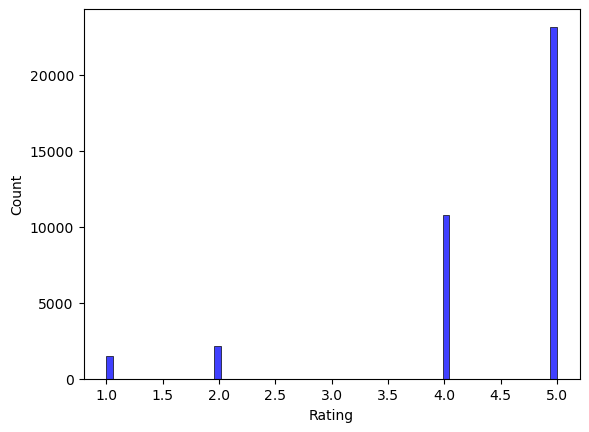

In [82]:
sns.histplot(df['Rating'], kde=False, color='blue')

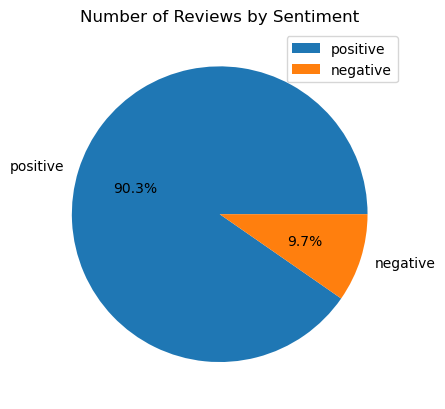

In [83]:
labels='positive','negative'
m=df['sentiment'].value_counts()
fig, ax = plt.subplots()
ax.pie(m, labels=labels, autopct='%1.1f%%')

ax.set_title("Number of Reviews by Sentiment")
ax.legend(loc="upper right")

The pie chart and bar chart both show that the data is very skewed. The majority of the reviews are positive.

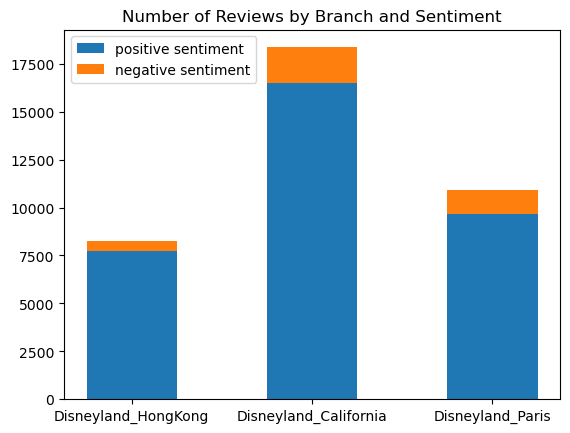

In [84]:
a= df[(df['Branch']=='Disneyland_HongKong') & (df['sentiment']==1)].__len__()
b= df[(df['Branch']=='Disneyland_California') & (df['sentiment']==1)].__len__()
c= df[(df['Branch']=='Disneyland_Paris') & (df['sentiment']==1)].__len__()

w= df[(df['Branch']=='Disneyland_HongKong') & (df['sentiment']==0)].__len__()
y= df[(df['Branch']=='Disneyland_California') & (df['sentiment']==0)].__len__()
z= df[(df['Branch']=='Disneyland_Paris') & (df['sentiment']==0)].__len__()

sentiments={
    'positive sentiment': np.array([a,b,c]),
    'negative sentiment': np.array([w,z,y]),
}

branches= df['Branch'].unique()

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, s in sentiments.items():
    p = ax.bar(branches, s, width, label=boolean, bottom=bottom)
    bottom += s

ax.set_title("Number of Reviews by Branch and Sentiment")
ax.legend(loc="upper left")

plt.show()


* The reviews are of the Hong Kong, California and Paris Disneyland branches
* The majority of the reviews are of the California Disneyland branch.
* The Hong Kong Disneyland branch had the least reviews.
* Negative reviews are the minority across all branches
* The California branch had the most negative reviews but also the most data
* The Hong Kong branch had the least negative reviews but also the least data



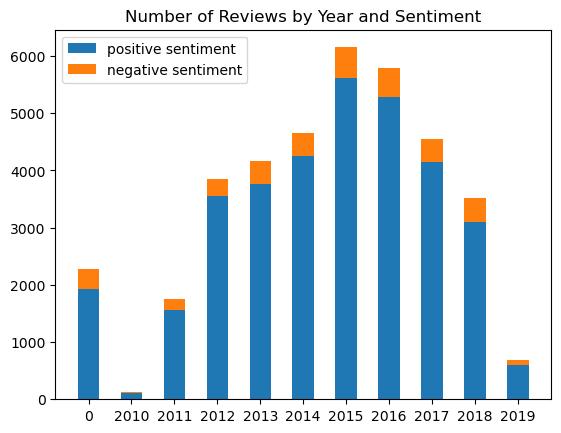

In [85]:
years=df['Year'].sort_values(ascending=True).unique()

pos=[]
for y in years:
    a= df[(df['Year']==y) & (df['sentiment']==1)].__len__()
    pos.append(a)

neg=[]
for y in years:
    a= df[(df['Year']==y) & (df['sentiment']==0)].__len__()
    neg.append(a)

sentiments={
    'positive sentiment':pos,
    'negative sentiment': neg,
}

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(years.__len__())

for boolean, s in sentiments.items():
    p = ax.bar(years, s, width, label=boolean, bottom=bottom)
    bottom += s

ax.set_title("Number of Reviews by Year and Sentiment")
ax.legend(loc="upper left")

* The reviews cover the period 2010 to 2019 
* The majority of the reviews were taken in 2015 and 2016
* The ratio of positive to negative reviews is consistent across most of the years, where positive reviews are the majority
* 2010 and 2019 have the least amount of negative reviews but also the least amount of data
* The '0' column represents missing data

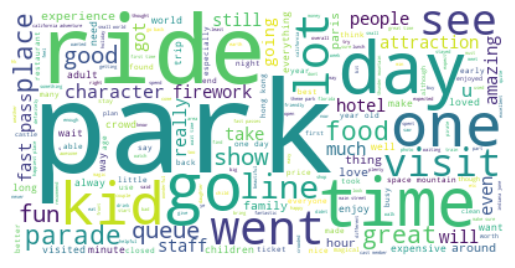

In [86]:
pos_text= df['Review_Text'][df['sentiment']==1]
text = " ".join(text for text in pos_text)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

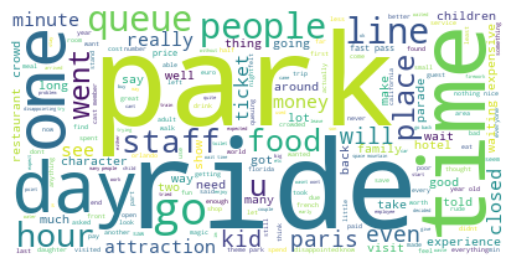

In [87]:
neg_text= df['Review_Text'][df['sentiment']==0]
text = " ".join(text for text in neg_text)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

* Both positive and negative reviews involved the Disneyland parks and rides
* Positive reviews metioned fireworks, attractions, food, the parade, hotels, characters as well as the queues and fast passes
* Negative reviews mentioned queues, lines, waiting and time. Staff, expensive prices and closed rides were also mentioned

# Text Classification

In [88]:
df.head(10)

,Rating,Reviewer_Location,Review_Text,Branch,Year,Month,sentiment
Review_ID,,,,,,,
670772142,4,Australia,if youve ever been to anywhere youll find hong...,Disneyland_HongKong,2019,4,1
670682799,4,Philippines,its been a while since d last time we visit hk...,Disneyland_HongKong,2019,5,1
670623270,4,United Arab Emirates,thanks god it wasn t too hot or too humid when...,Disneyland_HongKong,2019,4,1
670607911,4,Australia,hk is a great compact park unfortunately there...,Disneyland_HongKong,2019,4,1
670607296,4,United Kingdom,the location is not in the city took around ho...,Disneyland_HongKong,2019,4,1
670585330,5,India,great place your day will go by and you wont e...,Disneyland_HongKong,2019,4,1
670571027,2,Australia,feel so let down with this placethe train was ...,Disneyland_HongKong,2019,4,0
670570869,5,India,i can go on talking about whatever i say about...,Disneyland_HongKong,2019,3,1
670443403,5,United States,never cease to amaze me ive been to florida an...,Disneyland_HongKong,2019,4,1


In [89]:
X = df['Review_Text']

In [90]:
X.head(5)

Review_ID
670772142    if youve ever been to anywhere youll find hong...
670682799    its been a while since d last time we visit hk...
670623270    thanks god it wasn t too hot or too humid when...
670607911    hk is a great compact park unfortunately there...
670607296    the location is not in the city took around ho...
Name: Review_Text, dtype: object

In [91]:
y=df['sentiment']

In [92]:
y.head(5)

Review_ID
670772142    1
670682799    1
670623270    1
670607911    1
670607296    1
Name: sentiment, dtype: int64

F1 score will be used to assess the performance of the classifier because it is the harmonic mean of the precission and recall scores.  
 
Using the precision or recall scores may result in skewed false positives or false negatives sice they are inversely related and improving one will lower the sore of the other. Therefore precision score and recall score will not be used.
Accuracy score will not be used because it only takes into consideration number of correct predictions and is not sutable for imbalanced datasets.  

The skewness of the data implies that the models may not be able to accurately classify negative reviews.  
Therefore, Specificity will also be used. 

In [93]:
def text_fit(X, y, model, clf_model): #clf_model=classification model
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    specificity= tn/(fp+tn)
    print ('Model Specificity: {}'.format(specificity))
    score = f1_score(y_test,y_pred) 
    print ('Model F1-Score: {}'.format(score))
    return specificity, score

In [94]:
f1_scores=[]
specificities=[]
models=["Logistic Regression Model on word count", "Logistic Regression Model on TDIF","Support Vector Machine Model on word count", "Support Vector Machine Model on TDIF"]

#### Logistic Regression Model on word count

In [95]:
c = CountVectorizer(stop_words = 'english')
specificity, score=text_fit(X, y, c, LogisticRegression())
f1_scores.append(score)
specificities.append(specificity)

# features: 60428
# train records: 28160
# test records: 9387
Model Specificity: 0.6459770114942529
Model F1-Score: 0.9737178741714153


c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Logistic Regression Model on TDIF

In [96]:
tfidf = TfidfVectorizer(stop_words = 'english')
specificity,score= text_fit(X, y, tfidf, LogisticRegression())
f1_scores.append(score)
specificities.append(specificity)

# features: 60428
# train records: 28160
# test records: 9387
Model Specificity: 0.4896551724137931
Model F1-Score: 0.9713006543450808


#### Support Vector Machine Model on word count

In [97]:
c = CountVectorizer(stop_words = 'english')
specificity, score=text_fit(X, y, c, svm.SVC())
f1_scores.append(score)
specificities.append(specificity)

# features: 60428
# train records: 28160
# test records: 9387
Model Specificity: 0.38850574712643676
Model F1-Score: 0.9669501683886066


#### Support Vector Machine Model on TDIF

In [98]:
tfidf = TfidfVectorizer(stop_words = 'english')
specificity, score=text_fit(X, y, tfidf, svm.SVC())
f1_scores.append(score)
specificities.append(specificity)

# features: 60428
# train records: 28160
# test records: 9387
Model Specificity: 0.5195402298850574
Model F1-Score: 0.9720432581684308


In [99]:
data={'F1-Score': f1_scores, 'Specificity':specificities, 'Model': models}
models_df= pd.DataFrame(data)
models_df

,F1-Score,Specificity,Model
0,0.973718,0.645977,Logistic Regression Model on word count
1,0.971301,0.489655,Logistic Regression Model on TDIF
2,0.966950,0.388506,Support Vector Machine Model on word count
3,0.972043,0.519540,Support Vector Machine Model on TDIF


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Logistic Regression Model on word count'),
  Text(1, 0, 'Logistic Regression Model on TDIF'),
  Text(2, 0, 'Support Vector Machine Model on word count'),
  Text(3, 0, 'Support Vector Machine Model on TDIF')])

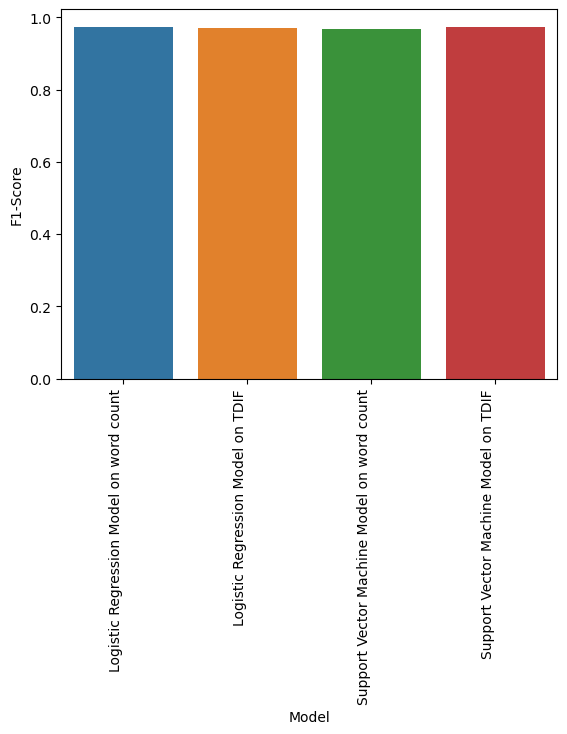

In [100]:
sns.barplot(x = 'Model',
            y = 'F1-Score',
            data = models_df)
plt.xticks(rotation=90, ha='right')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Logistic Regression Model on word count'),
  Text(1, 0, 'Logistic Regression Model on TDIF'),
  Text(2, 0, 'Support Vector Machine Model on word count'),
  Text(3, 0, 'Support Vector Machine Model on TDIF')])

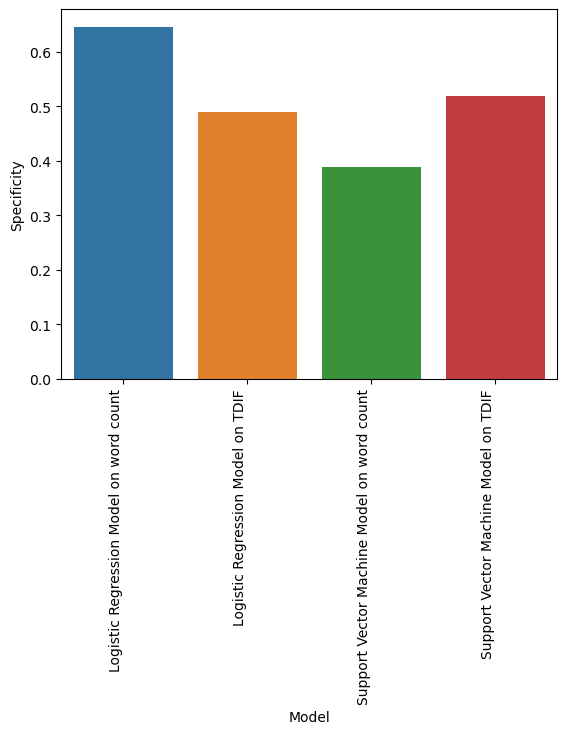

In [101]:
sns.barplot(x = 'Model',
            y = 'Specificity',
            data = models_df)
plt.xticks(rotation=90, ha='right')

* The Logistic Regression Model using the Count Vectorizer has the best performance. It has the highest F1 score and highest specificty.
* While the F1 scores for all the models are high, the specificity is poor. This is likely because the dataset and training set do not contain enough negative reviews 

# Topic Modeling

In [102]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])
            print("\n")

In [103]:
documents = list(X)[0:10000]
print(len(documents))

10000


# Using 5 topics

In [104]:
no_topics = 5

#### Topic Modelling with NMF

In [105]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [106]:
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [107]:
no_top_words = 10
no_top_documents = 4
print("NMF Topics \n\n")
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

NMF Topics 


Topic 0:
park rides time ride food small good long pass day


we had our first real family vacation in and it was amazing things to expect long entrance lines some people find this frustrating but the lines do move fairly quickly and they are checking everyone for your own safety we recommend hats sunscreen and water bottles during your time both in line and in the park they dont allow selfie sticks we lost because we had to surrender ours they did allow go pro sticks though which didnt seem fair considering they are virtually the same thing long ride lines get the max pass on your phone for fast passes it makes all the difference for those rides in high demand you can be in line for over an hour during peak times also find out which are the rides you want to hit that are most in demand and secure a fast pass for your magic morning if you get one with your park pass or hotel stay saves you time for sure crowds it sort of goes without saying but sees over visitors per day 

#### Topic Modelling with LDA

In [108]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [109]:
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

In [110]:
print("\n\nLDA Topics \n\n")
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)



LDA Topics 


Topic 0:
maxpass walt guardians galaxy springs fault radiator soaring village racers


tip ask for a senior ticket if you qualify as it is a quarter of the price of a childs ticket i wanted a photograph with a storm trooper but he turned his back on me and ssid that he was on patrol very in 


as a child in the i was brought up with walt his christmas message was always awaited on tv with complete silence nothing like the queens speech so parks from los angeles through florida to paris have been well frequented by ourmore 


unfortunately hk due to a fault in their website are still holding approx of my cash debit card weeks after i attempted to purchase tickets and the website kept advising me my card could not be authorised extremely poor unhelpful service from hk staff during my attempts to rectify this situation no magic in this experience 


if walt created a legacy through his creations the is the timeless heir of that legacy which will continue to carry on and bu

#### Topic Modelling with SVD

In [111]:
lsi_model = TruncatedSVD(n_components=no_topics, n_iter=7, random_state=42).fit(tf)
lsi_W = lsi_model.transform(tf)
lsi_H = lsi_model.components_

In [112]:
print("\n\nLSI Topics \n\n")
display_topics(lsi_H, lsi_W, tf_feature_names, documents, no_top_words, no_top_documents)



LSI Topics 


Topic 0:
park day rides time ride kids just food great good


first off it s therefore it s amazing and gets stars if you are worried your kid won t remember it who cares is magical in the moment you ll get great pictures and let s be honest it s fun for mom and dad so we recently took our old daughter who loves mickey to and here are my tips app download the app it has the map the events ride wait times where s the nearest bathroom where are the characters mobile food ordering and your tickets plus a hundred other things tickets get the day ticket with max pass and photopass you ll want days at and day at adventure california you can do more days and do rides multiple times you could also do it in days and skip some things either way spend at least of your time on the side my review for dac will be under that link on this site with photopass you ll get great photos from the photographers they scan a barcode in the app and all the pictures show up shortly after don t wo

| --- | Topic 1 | Topic 2 | Topic 3 | Topic 4 | Topic 5 |
| --- | --- | --- | --- | --- | --- |
| NMF | park rides time ride food small good long pass day | place kids visit enjoy love family fun happiest nice adults | kong hong visit smaller visited paris world parks compared tokyo | great day fun rides family lots spend kids went spent | parade fireworks night shows king lion miss mickey land characters |
| LDA | maxpass walt guardians galaxy springs fault radiator soaring village racers | park day rides time great hong kong visit fun small | place kids rides visit enjoy mountain land parade mickey really | park rides day time ride food pass just line fast | shoes wear comfortable baby selfie cast sticks everybody wheel members |
| SVD | park day rides time ride kids just food great good | park parks theme california hong kong florida magic attractions cast | time pass ride fast rides line wait park app passes | ride time like rides hong place kong just really kids | time ride hong kong pass fast line day just went |



The main topics of the reviews are about Food, Rides, Parade, Kids & Family and Disney Characters

# Using 3 topics

In [113]:
no_topics = 3

#### Topic Modelling with NMF

In [114]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_
no_top_words = 10
no_top_documents = 4
print("NMF Topics \n\n")
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


NMF Topics 


Topic 0:
park day rides time ride great food good went just


we had our first real family vacation in and it was amazing things to expect long entrance lines some people find this frustrating but the lines do move fairly quickly and they are checking everyone for your own safety we recommend hats sunscreen and water bottles during your time both in line and in the park they dont allow selfie sticks we lost because we had to surrender ours they did allow go pro sticks though which didnt seem fair considering they are virtually the same thing long ride lines get the max pass on your phone for fast passes it makes all the difference for those rides in high demand you can be in line for over an hour during peak times also find out which are the rides you want to hit that are most in demand and secure a fast pass for your magic morning if you get one with your park pass or hotel stay saves you time for sure crowds it sort of goes without saying but sees over visitors per day 

c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


#### Topic Modelling with LDA

In [115]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_
print("\n\nLDA Topics \n\n")
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)



LDA Topics 


Topic 0:
line people park staff cast just members security told maxpass


hand dipped with thick corn batter to crispy perfection ketchup and mustard behind corn dog cart can buy corn dog separately and not with apple slices and drink 


the service staff manning the queue at cinderella photo taking spoil the day for my whole familyincident happened on at around directed to push my baby pram underneath the queue line then when i was trying to get under the queue linethe guy then pulled the rope quite forcefully and it hit my head which he did not even apologise but instead he shouted in a very rude mannerpls note that i do not understand cantonese and i was just following his gesturesuper bad experience manzdoesnt reflect on at alldoes encourages violences and rudeness as well as bad service and attitude 


we brought along two seniors who required wheelchair assistance the park was well aware of the situation and had offered their full assistance the seniors were treat

#### Topic Modelling with SVD

In [116]:
lsi_model = TruncatedSVD(n_components=no_topics, n_iter=7, random_state=42).fit(tf)
lsi_W = lsi_model.transform(tf)
lsi_H = lsi_model.components_
print("\n\nSVD Topics \n\n")
display_topics(lsi_H, lsi_W, tf_feature_names, documents, no_top_words, no_top_documents)



SVD Topics 


Topic 0:
park day rides time ride kids just food great good


first off it s therefore it s amazing and gets stars if you are worried your kid won t remember it who cares is magical in the moment you ll get great pictures and let s be honest it s fun for mom and dad so we recently took our old daughter who loves mickey to and here are my tips app download the app it has the map the events ride wait times where s the nearest bathroom where are the characters mobile food ordering and your tickets plus a hundred other things tickets get the day ticket with max pass and photopass you ll want days at and day at adventure california you can do more days and do rides multiple times you could also do it in days and skip some things either way spend at least of your time on the side my review for dac will be under that link on this site with photopass you ll get great photos from the photographers they scan a barcode in the app and all the pictures show up shortly after don t wo

| --- | Topic 1 | Topic 2 | Topic 3 |
| --- | --- | --- | --- |
| NMF | park day rides time ride great food good went just | place kids visit enjoy fun family love great parade adults | kong hong visit smaller visited paris world parks park small |
| LDA | line people park staff cast just members security told maxpass | park day rides time ride great food pass just hong | place kids rides visit time day parade great fun characters |
| SVD | park day rides time ride kids just food great good | park parks theme california hong kong florida magic attractions cast | time pass ride fast rides line wait park app passes |

Based on the top 10 words for the three topics, the topics correspond to the following catgories: Food, Rides, Lines & Passes


# Conclusions

* Disneyland reviews of the branches in California, Hong Kong and Paris are mostly positive. 
* The main topics of the reviews are Food, Rides and Lines & Passes
* People who were satisfied with their experience typically enjoyed the food, Disney characters, attractions, the fireworks and parade. The Disneyland Fast Pass also contributed towards a positive experience.
* People who were dissatisfied with their experience were usually displeased with long lines and time spent waiting, expensive prices, closed rides and the staff.
* Several models were tested to classify reviews as negative or positive. The Logistic Regression Model using the Count Vectorizer had the best performance. It had an F1 score of 97.4% and a specificity of 64.6% 
* All models had poor specificty (true negative rate) because of the small amount of negative reviews